### Nome: Marcelo Adriel Moresco

In [ ]:
!pip install kaggle
!pip install tensorflow
!pip install tensorflowjs


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 113.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully un

In [ ]:
from google.colab import files
files.upload() # kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d haroonalam16/20-skin-diseases-dataset

import zipfile
import os

with zipfile.ZipFile('20-skin-diseases-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('skin_diseases')



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/haroonalam16/20-skin-diseases-dataset
License(s): other
 99% 319M/321M [00:11<00:00, 31.5MB/s]
100% 321M/321M [00:11<00:00, 28.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Rescaling)
from tensorflow.keras.models import Sequential
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



In [ ]:
# path teste e train
train_dir = '/content/skin_diseases/Dataset/train'
test_dir = '/content/skin_diseases/Dataset/test'


# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

img_size = (192, 192, 3)

print('classes: ', class_names)

Found 2609 images belonging to 19 classes.
Found 897 images belonging to 20 classes.
classes:  ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

labels = []
images = []

print('Carregando imagens:\n')
for cl in class_names:
    print(f'{cl} -> ', end='')
    class_path = os.path.join(train_dir, cl)
    image_files = os.listdir(class_path)
    for img_name in tqdm(image_files):
        img_path = os.path.join(class_path, img_name)
        try:
            # Ler a imagem usando cv2
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Aviso: Não foi possível ler a imagem {img_path}")
                continue

            # Converter de BGR para RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Redimensionar a imagem
            img_resized = cv2.resize(img_rgb, (img_size[0], img_size[1]))

            # Normalizar a imagem para valores entre 0 e 1
            img_normalized = img_resized / 255.0

            images.append(img_normalized)
            labels.append(cl)
        except Exception as e:
            print(f"Erro ao processar a imagem {img_path}: {e}")
            continue
    print('concluído')

# Converter listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

print(f'\n\nFormato dos labels: {labels.shape}')
print(f'Formato das imagens: {images.shape}')

# Codificar os labels usando LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=num_classes)

print(f'Formato dos labels codificados: {labels_categorical.shape}')


Carregando imagens:

Acne and Rosacea Photos -> 

100%|██████████| 840/840 [00:03<00:00, 265.33it/s]


concluído
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions -> 

100%|██████████| 322/322 [00:01<00:00, 254.79it/s]


concluído
Atopic Dermatitis Photos -> 

100%|██████████| 100/100 [00:00<00:00, 290.44it/s]


concluído
Cellulitis Impetigo and other Bacterial Infections -> 

100%|██████████| 65/65 [00:00<00:00, 246.31it/s]


concluído
Eczema Photos -> 

100%|██████████| 35/35 [00:00<00:00, 259.37it/s]


concluído
Exanthems and Drug Eruptions -> 

100%|██████████| 20/20 [00:00<00:00, 223.37it/s]


concluído
Herpes HPV and other STDs Photos -> 

100%|██████████| 40/40 [00:00<00:00, 266.34it/s]


concluído
Light Diseases and Disorders of Pigmentation -> 

100%|██████████| 299/299 [00:01<00:00, 266.40it/s]


concluído
Lupus and other Connective Tissue diseases -> 

100%|██████████| 90/90 [00:00<00:00, 266.16it/s]


concluído
Melanoma Skin Cancer Nevi and Moles -> 

100%|██████████| 24/24 [00:00<00:00, 293.61it/s]


concluído
Poison Ivy Photos and other Contact Dermatitis -> 

100%|██████████| 62/62 [00:00<00:00, 263.94it/s]


concluído
Psoriasis pictures Lichen Planus and related diseases -> 

100%|██████████| 62/62 [00:00<00:00, 263.59it/s]


concluído
Seborrheic Keratoses and other Benign Tumors -> 

100%|██████████| 80/80 [00:00<00:00, 266.11it/s]


concluído
Systemic Disease -> 

100%|██████████| 81/81 [00:00<00:00, 257.39it/s]


concluído
Tinea Ringworm Candidiasis and other Fungal Infections -> 

100%|██████████| 122/122 [00:00<00:00, 256.07it/s]


concluído
Urticaria Hives -> 

100%|██████████| 3/3 [00:00<00:00, 216.22it/s]


concluído
Vascular Tumors -> 

100%|██████████| 101/101 [00:00<00:00, 223.89it/s]


concluído
Vasculitis Photos -> 

100%|██████████| 15/15 [00:00<00:00, 168.29it/s]


concluído
Warts Molluscum and other Viral Infections -> 

100%|██████████| 248/248 [00:01<00:00, 184.62it/s]


concluído


Formato dos labels: (2609,)
Formato das imagens: (2609, 192, 192, 3)
Formato dos labels codificados: (2609, 19)


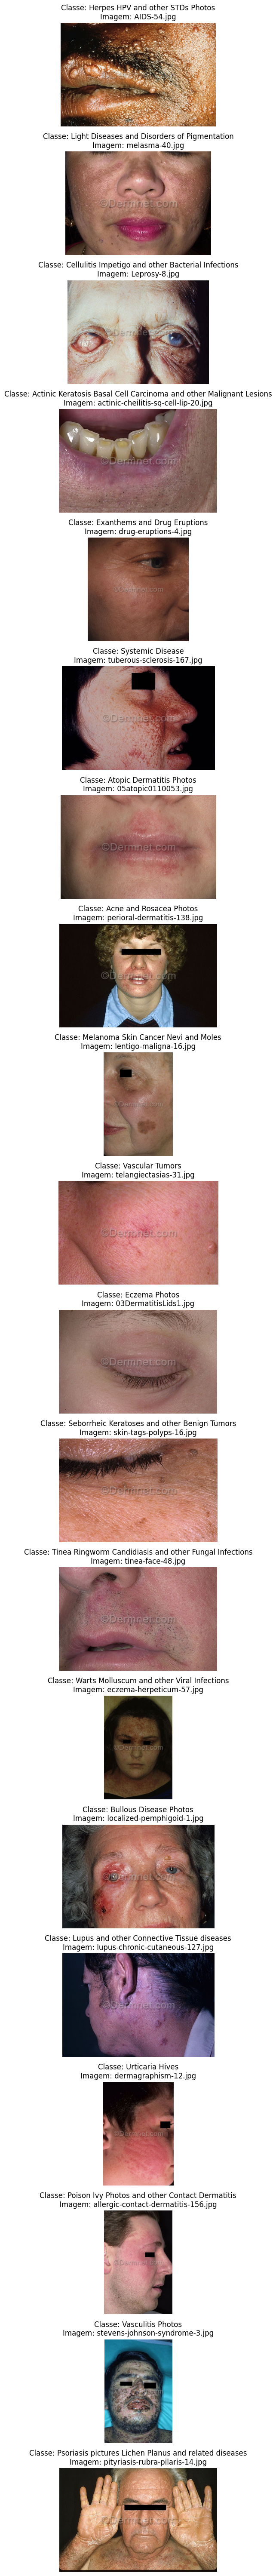

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Caminho do diretório de teste
test_dir = '/content/skin_diseases/Dataset/test'

# Listar as subpastas (classes)
classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

# Mostrar uma imagem de cada classe
fig, axs = plt.subplots(len(classes), 1, figsize=(10, len(classes) * 3))
for i, cls in enumerate(classes):
    class_dir = os.path.join(test_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Selecionar uma imagem aleatória
    random_image = random.choice(images)
    image_path = os.path.join(class_dir, random_image)

    # Abrir e mostrar a imagem
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Classe: {cls}\nImagem: {random_image}")

plt.tight_layout()
plt.show()


In [ ]:
derma_check_model = tf.keras.Sequential()

# Convolutional block 1
derma_check_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_size))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
derma_check_model.add(tf.keras.layers.Dropout(0.25))

# Convolutional block 2
derma_check_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
derma_check_model.add(tf.keras.layers.Dropout(0.25))

# Convolutional block 3
derma_check_model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
derma_check_model.add(tf.keras.layers.Dropout(0.25))

# Flatten and Dense layers
derma_check_model.add(tf.keras.layers.Flatten())
derma_check_model.add(tf.keras.layers.Dense(256, activation='relu'))
derma_check_model.add(tf.keras.layers.BatchNormalization())
derma_check_model.add(tf.keras.layers.Dropout(0.5))
derma_check_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compilar o modelo
derma_check_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

derma_check_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192, 192, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 192, 192, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 96, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 96, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,903,891 (148.41 MB)

 Trainable params: 38,901,587 (148.40 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.15, random_state=42)
print(f'X_TRAIN -> {X_train.shape}\n Y_TRAIN -> {y_train.shape}\n\n X_VAL ->: {X_val.shape}\n Y_VAL ->: {y_val.shape}\n')


X_TRAIN -> (2217, 192, 192, 3)
 Y_TRAIN -> (2217, 19)

 X_VAL ->: (392, 192, 192, 3)
 Y_VAL ->: (392, 19)



In [ ]:
history = derma_check_model.fit(images, labels_categorical, epochs=14, validation_data=(X_val, y_val))


Epoch 1/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 77s 572ms/step - accuracy: 0.1718 - loss: 3.5137 - val_accuracy: 0.3265 - val_loss: 15.5765
Epoch 2/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.2870 - loss: 2.7058 - val_accuracy: 0.3265 - val_loss: 23.8332
Epoch 3/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.3782 - loss: 2.2416 - val_accuracy: 0.3265 - val_loss: 11.1814
Epoch 4/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.4784 - loss: 1.8533 - val_accuracy: 0.3265 - val_loss: 7.2121
Epoch 5/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.6033 - loss: 1.4785 - val_accuracy: 0.3265 - val_loss: 5.6018
Epoch 6/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.7078 - loss: 1.1217 - val_accuracy: 0.3418 - val_loss: 4.3361
Epoch 7/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.7814 - loss: 0.8417 - val_accuracy: 0.4082 - val_loss: 2.9473
Epoch 8/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.8296 - loss: 0.6978 - val_a

In [ ]:
derma_check_model.save("model_derma_check_v2_oficial.h5")

In [ ]:
saved_model_path = '/content/model_derma_check'
tf.saved_model.save(derma_check_model, saved_model_path)


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/model_derma_check /content/derma_check_graph_model

2024-12-05 01:59:03.078689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733363943.100362    8231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733363943.106736    8231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-12-05 01:59:06.725510: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1733363946.725678    8231 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
import shutil

# Nome da pasta gerada pelo tensorflowjs_converter
folder_path = "/content/derma_check_graph_model"
zip_path = "/content/derma_check_graph_model.zip"

# Compactar a pasta em um arquivo ZIP
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print(f"Modelo compactado em: {zip_path}")


Modelo compactado em: /content/derma_check_graph_model.zip


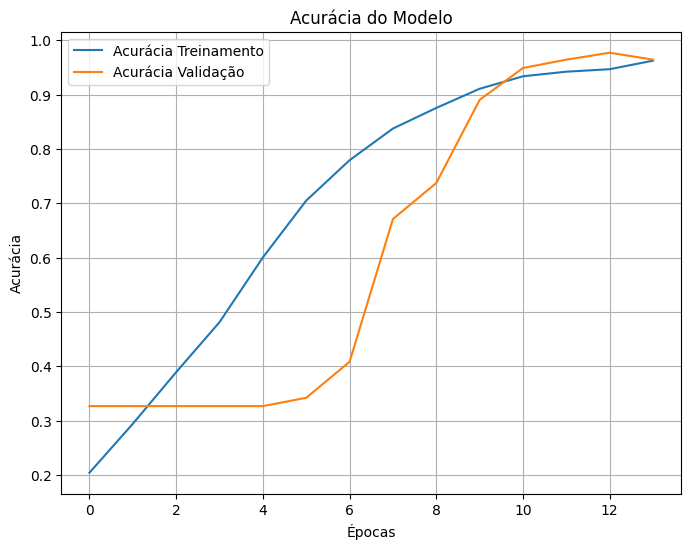

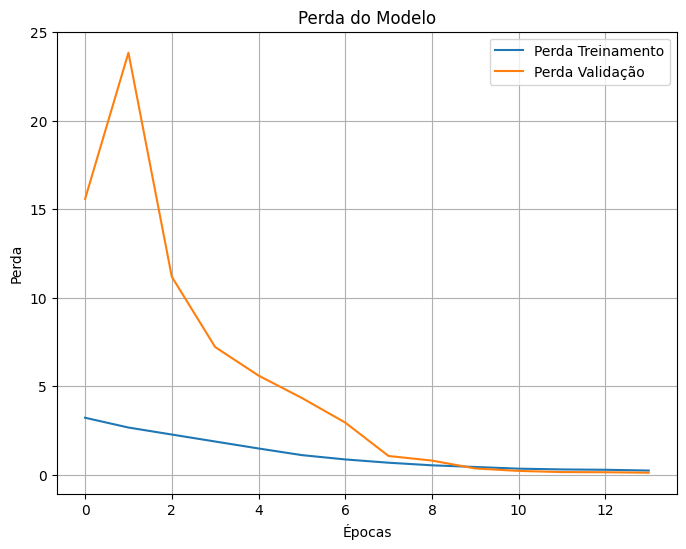

In [ ]:
# Gerar gráficos com os dados do histórico de treinamento
# Plotando Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()

# Plotando Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid()
plt.show()


Faça o upload de uma imagem para teste:


Saving Acne_vulgaris_on_a_very_oily_skin.jpg to Acne_vulgaris_on_a_very_oily_skin.jpg
Arquivo carregado: Acne_vulgaris_on_a_very_oily_skin.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


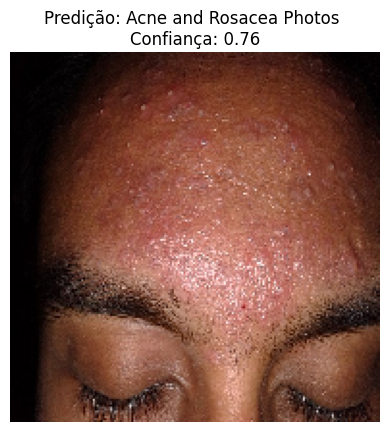

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import matplotlib.pyplot as plt

# Carregar o modelo salvo
model_path = "/content/model_derma_check_v2.h5"  # Atualize com o caminho correto, se necessário
model = tf.keras.models.load_model(model_path)


# Função para pré-processar a imagem
def preprocess_image(image_path, target_size=(192, 192)):
    img = load_img(image_path, target_size=target_size)  # Carregar imagem e redimensionar
    img_array = img_to_array(img)  # Converter para array NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch
    img_array = img_array / 255.0  # Normalizar para o intervalo [0, 1]
    return img_array, img

# Função para fazer a previsão com limiar
def predict_image(image_path, threshold=0.1):
    img_array, img = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Pegar a classe com maior probabilidade
    confidence = predictions[0][predicted_class]

    # Mostrar imagem com o resultado
    plt.imshow(img)
    plt.axis('off')

    # Verificar se a confiança está abaixo do limiar
    plt.title("Predição: Não identificado \nConfiança insuficiente")
    plt.title(f"Predição: {class_names[predicted_class]} \nConfiança: {confidence:.2f}")
    plt.show()

# Carregar uma imagem do computador
print("Faça o upload de uma imagem para teste:")
uploaded = files.upload()

# Testar com a imagem carregada
for file_name in uploaded.keys():
    print(f"Arquivo carregado: {file_name}")
    predict_image(file_name, threshold=0.5)  # Ajuste o limiar conforme necessário
